# -*- coding: utf-8 -*-

RNN used in the comment detection class

## Definition of RNN

Recurrent Neural Networks (RNNs) are a class of artificial neural networks designed for processing sequential data. Unlike feedforward neural networks, which process input data in a single forward pass, RNNs are capable of capturing and modeling temporal dependencies within the data. This makes them well-suited for tasks involving sequences, such as time series data, natural language processing, speech recognition, and more.

In [1]:
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

/Users/cash/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/cash/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


# Data loading

In [2]:
dataset = load_dataset('imdb')
df_train = pd.DataFrame.from_dict(
    {
        'comment': dataset['train']['text'],
        'label': dataset['train']['label']
    }
)
df_test = pd.DataFrame.from_dict(
    {
        'comment': dataset['test']['text'],
        'label': dataset['test']['label']
    }
)
punctuation_characters = '.!?,()[]{}"\''
for punctuation in punctuation_characters:
    df_train['comment'] = df_train.comment.str.replace(punctuation, f' {punctuation} ')

df_train['comment'] = df_train.comment.str.lower()
df_test['comment'] = df_test.comment.str.lower()

df_train.sample(10)

df_test.sample(10)

Found cached dataset imdb (/Users/cash/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

,comment,label
11936,"ladies and gentlemen, allow us to introduce to...",0
8331,one of the greatest lessons i ever had in how ...,0
15634,"in crystal city, a group of mormons hire the h...",1
8762,the relationship between the lone ranger and t...,0
17880,in the line of fire gives us a great game of c...,1
16796,fellowe's drama about a couple's marriage whic...,1
19632,"a great story, although one we are certainly f...",1
12185,this film could have been great- but wasn't. a...,0
22916,"spoilers: this movie has it's problems, but in...",1
12530,"well, i have to disagree with leonard maltin o...",1


# Text preprocessing
Let's begin preprocessing our data. The first thing we need to do is to *tokenize* our comments. We transform every comment into a list of word by using `split`. We will also add a `n_tokens` column into `df_train` to visualize the comment length distribution.



In [3]:
df_train['split_comment'] = df_train.comment.str.split()
df_train['n_tokens'] = df_train.split_comment.apply(len)
df_test['split_comment'] = df_test.comment.str.split()

# Let's now display an histogram of the comment lengths. 
Starting from the course code, you can change the `bins` parameter of the model to change the resolution of the histogram."""




<Axes: >

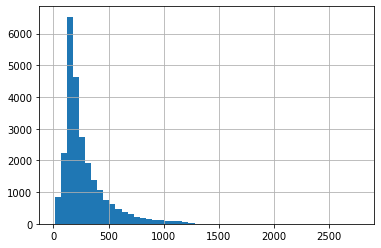

In [4]:
df_train.n_tokens.hist(bins = 50)

# As we can see in this histogram, the comment length distribution has a very long tail. 
To prevent the model from having to work with extremely long sequences all the time, we are going to truncate our sequences to 500 tokens. 

To do this, we will use the same code as we used in the course.
"""

In [6]:
def pad_comment(token_list, final_len, pad_token = '<pad>'):
  if len(token_list) > final_len:
    return token_list[:final_len]
  return token_list + [pad_token] * (final_len - len(token_list))

max_token_comment = 500
df_train['padded_comment'] = df_train.split_comment.apply(
    partial(
        pad_comment,
        final_len = max_token_comment
    )
)
df_test['padded_comment'] = df_test.split_comment.apply(
    partial(
        pad_comment,
        final_len = max_token_comment
    )
)

print(df_train.padded_comment.iloc[1])

['"', 'i', 'am', 'curious:', 'yellow', '"', 'is', 'a', 'risible', 'and', 'pretentious', 'steaming', 'pile', '.', 'it', 'doesn', "'", 't', 'matter', 'what', 'one', "'", 's', 'political', 'views', 'are', 'because', 'this', 'film', 'can', 'hardly', 'be', 'taken', 'seriously', 'on', 'any', 'level', '.', 'as', 'for', 'the', 'claim', 'that', 'frontal', 'male', 'nudity', 'is', 'an', 'automatic', 'nc-17', ',', 'that', 'isn', "'", 't', 'true', '.', 'i', "'", 've', 'seen', 'r-rated', 'films', 'with', 'male', 'nudity', '.', 'granted', ',', 'they', 'only', 'offer', 'some', 'fleeting', 'views', ',', 'but', 'where', 'are', 'the', 'r-rated', 'films', 'with', 'gaping', 'vulvas', 'and', 'flapping', 'labia', '?', 'nowhere', ',', 'because', 'they', 'don', "'", 't', 'exist', '.', 'the', 'same', 'goes', 'for', 'those', 'crappy', 'cable', 'shows:', 'schlongs', 'swinging', 'in', 'the', 'breeze', 'but', 'not', 'a', 'clitoris', 'in', 'sight', '.', 'and', 'those', 'pretentious', 'indie', 'movies', 'like', 'the'

# Now that we have created our training samples, 
it is time to build our vocabulary. The vocabulary is simply the set of words that can happen in our comments. If we want to test our model on comments using words that are out of our vocabulary, we will replace them with the token `<oov>` (Out Of Vocabulary)."""



In [7]:
vocabulary = set()
for comment in df_train.split_comment:
  vocabulary.update(set(comment))
print(*list(vocabulary)[:5], sep = '\n')

1914
merging
elements:
later-on
zanatos


# Using the newly created vocabulary, 
we can build `token_to_idx` and `idx_to_token` mappings that we will use to encode sequences prior to feeding them to the model."""



In [8]:
token_to_idx = {
    '<oov>': 0,
    '<pad>': 1,
    **{
        token: (idx + 2)
        for idx, token in enumerate(vocabulary)
    }
}

print('Number of words in the vocabulary:', len(token_to_idx))
print(token_to_idx['<pad>'])
print(token_to_idx['the'])
print(token_to_idx['happy'])

idx_to_token = {
    idx: token
    for token, idx in token_to_idx.items()
}
print(idx_to_token[6477])
print(idx_to_token[1234])

def encode(comment_tokens, token_to_idx):
  return [token_to_idx.get(token, 0) for token in comment_tokens]

def decode(comment_token_indices, idx_to_token):
  try:
    first_pad_index = comment_token_indices.index(1)
  except:
    first_pad_index = len(comment_token_indices)
  return ' '.join(idx_to_token[token_id] for token_id in comment_token_indices[:first_pad_index])

comment = df_train.padded_comment.iloc[3]
print(comment[:15])


encoded_comment = encode(comment, token_to_idx)
print(encoded_comment[:15])
print(decode(encoded_comment, idx_to_token))

Number of words in the vocabulary: 111749
1
72575
101821
self-appointed
injury/condition
['this', 'film', 'was', 'probably', 'inspired', 'by', 'godard', "'", 's', 'masculin', ',', 'féminin', 'and', 'i', 'urge']
[86590, 59714, 13484, 83609, 54871, 96542, 109586, 75588, 47598, 37403, 28494, 69383, 51236, 74269, 39978]
this film was probably inspired by godard ' s masculin , féminin and i urge you to see that film instead . <br /><br />the film has two strong elements and those are , ( 1 ) the realistic acting ( 2 ) the impressive , undeservedly good , photo . apart from that , what strikes me most is the endless stream of silliness . lena nyman has to be most annoying actress in the world . she acts so stupid and with all the nudity in this film , . . . it ' s unattractive . comparing to godard ' s film , intellectuality has been replaced with stupidity . without going too far on this subject , i would say that follows from the difference in ideals between the french and the swedish soci

# We can now add `encoded_comment` columns to both `df_train` 
and `df_test` to encode all of our model inputs. """



In [9]:
df_train['encoded_comment'] = df_train.padded_comment.apply(
    partial(
        encode,
        token_to_idx = token_to_idx
    )
)
df_test['encoded_comment'] = df_test.padded_comment.apply(
    partial(
        encode,
        token_to_idx = token_to_idx
    )
)

df_train['encoded_comment'] = df_train['padded_comment'].apply(
    lambda x: encode(x, token_to_idx)
)

df_test['encoded_comment'] = df_test['padded_comment'].apply(
    lambda x: encode(x, token_to_idx)
)

print(df_train.head())  # Affiche un extrait des données d'entraînement


                                             comment  label  \
0  i rented i am curious-yellow from my video sto...      0   
1   " i am curious: yellow "  is a risible and pr...      0   
2  if only to avoid making this type of film in t...      0   
3  this film was probably inspired by godard ' s ...      0   
4  oh ,  brother .  .  . after hearing about this...      0   

                                       split_comment  n_tokens  \
0  [i, rented, i, am, curious-yellow, from, my, v...       325   
1  [", i, am, curious:, yellow, ", is, a, risible...       258   
2  [if, only, to, avoid, making, this, type, of, ...       108   
3  [this, film, was, probably, inspired, by, goda...       152   
4  [oh, ,, brother, ., ., ., after, hearing, abou...       408   

                                      padded_comment  \
0  [i, rented, i, am, curious-yellow, from, my, v...   
1  [", i, am, curious:, yellow, ", is, a, risible...   
2  [if, only, to, avoid, making, this, type, of, ...   


# We build our `train_dataset` and `test_dataset` 
using the `encoded_comment` columns of both DataFrames."""



In [10]:
X_train = torch.tensor(df_train.encoded_comment)
y_train = torch.tensor(df_train.label)
X_test = torch.tensor(df_test.encoded_comment)
y_test = torch.tensor(df_test.label)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader  = DataLoader(test_dataset, batch_size = 32, shuffle = False)

# NLP model

We use the same `train` and `eval` function as the ones in the course with a `device` configuration added to be able to train and evaluate models on GPUs.
"""

In [10]:

def eval(model, device, loader):
    model.eval()
    correct_pred = 0
    total_pred   = 0
    with torch.no_grad():
        for X, y in loader:
            X             = X.to(device)
            y             = y.to(device)
            y_pred        = model(X)
            y_pred_class  = y_pred.argmax(dim = 1)
            correct_pred += (y == y_pred_class).sum().cpu().item()
            total_pred   += len(y)

    return correct_pred / total_pred

def train(model, device, epochs, optimizer, criterion, train_loader, test_loader):
    for epoch in range(epochs):
        model.train()
        for batch_id, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss   = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
        if epoch % 5 == 0:
            print(f'[{epoch:4}] Train eval {100 * eval(model, device, train_loader):5.3f}%, Test eval {100 * eval(model, device, test_loader):5.3f}%')

# We modify the class in order to add a RNN

In [11]:
class RNNCommentClassifier(nn.Module):
    def __init__(self, emb_dim, voc_size, seq_len):
        super(RNNCommentClassifier, self).__init__()
        self.emb      = nn.Embedding(voc_size, emb_dim)
        self.rnn     = nn.LSTM(
            input_size    = emb_dim,
            hidden_size   = 64,
            bidirectional = True,
            dropout       = 0    
        )
        self.dropout = nn.Dropout(.2) # 2 directions
        self.lin     = nn.Linear(64 * 2, 2)

    def forward(self, x):                   # [batch, 72 >> expliquer comment ?]
        x = self.emb(x)                     # [batch, 72, 5]
        x = torch.transpose(x, 0, 1)        # [72, batch,  5]
        
        output, (hidden, cell) = self.rnn(x)
        
        hidden                 = torch.transpose(hidden, 0, 1)
        hidden                 = torch.cat((
            hidden[:, 0, :],
            hidden[:, 1, :]
        ),
            dim = -1
        )
        hidden                 = self.dropout(hidden)
        x                      = self.lin(hidden)
        x                      = torch.log_softmax(x, dim = 1)
    
    
        return x

# Model testing on our own comment

Now that our model is trained, we can test it on new comments to see how it performs. We will need to apply all the preprocessing steps that we applied on our datasets in order to feed the new data to the model.
"""

In [ ]:
import torch

device = torch.device('cpu')
model = RNNCommentClassifier(
    emb_dim  = 5,
    voc_size = len(token_to_idx),
    seq_len  = train_dataset[0][0].shape[0]
).to(device)


print(model)

optimizer = optim.Adam(model.parameters())
criterion = nn.NLLLoss()
train(model, device, 151, optimizer, criterion, train_loader, test_loader)

# our_comment = input()
# our_comment = '''My god, that was AWFUL. Just random made-for-trailer tiny scenes that add to nothing, have zero depth and don't make up a coherent plot. Wall-to-wall inappropriate songs that come at random times. Boring plot (if you can even call it that), boring and indistinguishable flat characters. Harley Quinn was annoying. Jared Leto did his best as The Joker but had absolutely nothing to work with - he just appears at random times for a few seconds and disappears. There's no depth and no story. If you've seen the trailers, you basically saw all the one-liners and "money shots".

# If all that isn't enough, the last third of the movie is simply unwatchable.

# I don't think David Ayer is a bad director (I liked HARSH TIMES and FURY), but this is definitely his worst movie yet and I'm pretty sure it's due to massive pressure from the producers.'''
#our_comment = '''Fight Club is one of the most unique films I have ever seen. In addition to presenting a rather fresh take on life, FC also presents its material in a fresh way. My main interest in the film is in that, in my opinion, it does not present characters for us to think about. Rather, it presents actions for us to think about. I will say that I cannot recall *ever* having been "asked" by a film to both suspend my disbelief the way this film asks in its third act AND at the same time come to terms with an understanding that there is no room--or need--for disbelief.

#Perhaps these comments will not make sense to the average movie goer who will dismiss this film--and, unfortunately, its premise--as another hollywood flick filled with gratuitous violence. I'd go as far as to say that this film is not about violence. It is about choices. It is about activity. It is about lethargy. It is about waking up and realizing that at some point in the past we've gone to the toilet and thrown up our dreams without even realizing that society has stuck its fingers down our throat.

#I would argue that anyone caught, at some point in their lives, between a rock and a hard place--anyone who has reached bottom on a mental level--anyone who has uttered to themselves "Wait, this isn't right. I would not do/say/feel what it is that I just did/said/felt... I do not like this. I must change before I am forever stuck being the person that I am not." These people, they will know what I'm talking about. These people will not only recognize the similarities between Edward Norton's character and themselves--they will be uncomfortably familiar with him. These people will appreciate Fight Club for what it is: a wake up call that we are not alone.

#As David Berman once said: "I'm afraid I've got more in common with who I was than who I am becoming." If this sentence makes any sense to you, go see Fight Club. You won't regret it.

#L.'''

our_comment = "I loved the movie, however it is sadly yet another film seen recently, hence some reiteration because the exact same strengths and flaws are here present in those films, that to me was  disappointing considering its potential which it doesn't do anywhere near enough with."

for punctuation in punctuation_characters:
    our_comment = our_comment.replace(punctuation, f' {punctuation} ')
print('Our comment:', our_comment)

our_comment_split = our_comment.lower().split()
print('Our tokenized comment:', our_comment_split)

our_comment_padded = pad_comment(our_comment_split, max_token_comment)
print('Our comment padded:', our_comment_padded[:20])

our_comment_encoded = encode(our_comment_padded, token_to_idx)
print('Our comment encoded:', our_comment_encoded[:20])

our_comment_tensor = torch.tensor(our_comment_encoded)
print('Our comment tensor shape:', our_comment_tensor.shape)



RNNCommentClassifier(
  (emb): Embedding(111749, 5)
  (rnn): LSTM(5, 64, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (lin): Linear(in_features=128, out_features=2, bias=True)
)
[   0] Train eval 57.012%, Test eval 53.844%
[   5] Train eval 81.680%, Test eval 63.180%
[  10] Train eval 89.896%, Test eval 60.784%
[  15] Train eval 94.772%, Test eval 54.724%


# PyTorch models always work with batches of data. 
As we only have a single sample, we simply reshape it to `[1, 500]` to make it a set of 1 example of length 500."""

In [ ]:
our_comment_batch = our_comment_tensor.unsqueeze(0)
our_comment_batch = our_comment_batch.to(device)
print('Our comment batch shape:', our_comment_batch.shape)

model_pred = model(our_comment_batch)[0]
print('Log-Softmax output of the model:', model_pred)   # the model output is the logarithm of the softmax values
print('Softmax output of the model:', model_pred.exp()) # to get the real softmax values, we simply take the exponential

confidence_negative, confidence_positive = model_pred.exp().cpu().detach().numpy()
print('Our comment was:', our_comment)
print('\nThe model prediction are:')
print(f'\t{100 * confidence_negative:5.3f}% for the negative class')
print(f'\t{100 * confidence_positive:5.3f}% for the positive class.')

# Print the result

MLPCommentClassifier(
  (emb): Embedding(111749, 100)
  (lin1): Linear(in_features=50000, out_features=64, bias=True)
  (dropout1): Dropout(p=0.7, inplace=False)
  (lin2): Linear(in_features=64, out_features=64, bias=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (lin3): Linear(in_features=64, out_features=2, bias=True)
)
[   0] Train Loss: 0.7328, Train Acc: 0.5032, Test Acc: 0.5000
[   5] Train Loss: 0.6860, Train Acc: 0.5116, Test Acc: 0.5014
[  10] Train Loss: 0.6834, Train Acc: 0.5132, Test Acc: 0.4997
[  15] Train Loss: 0.6878, Train Acc: 0.5106, Test Acc: 0.5036
[  20] Train Loss: 0.6790, Train Acc: 0.5146, Test Acc: 0.5032
[  25] Train Loss: 0.6794, Train Acc: 0.5154, Test Acc: 0.5040
[  30] Train Loss: 0.6796, Train Acc: 0.5140, Test Acc: 0.5040
[  35] Train Loss: 0.6772, Train Acc: 0.5128, Test Acc: 0.5039
[  40] Train Loss: 0.6782, Train Acc: 0.5151, Test Acc: 0.5030
[  45] Train Loss: 0.6773, Train Acc: 0.5153, Test Acc: 0.5046
[  50] Train Loss: 0.6779, Train Acc: 0.5

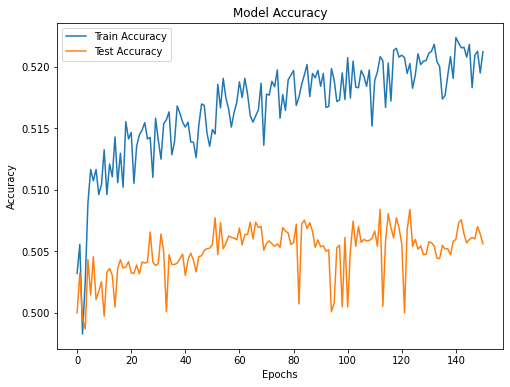

In [55]:
device = torch.device('cpu')
model = MLPCommentClassifier(
    emb_dim=100,
    voc_size=len(token_to_idx),
    seq_len=max_token_comment
).to(device)
print(model)

optimizer = optim.Adam(model.parameters())
criterion = nn.NLLLoss()
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(151):
    model.train()
    epoch_train_losses = []
    correct_pred = 0
    total_pred = 0
    for batch_id, (X, y) in enumerate(train_loader):
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.item())

        y_pred_class = y_pred.argmax(dim=1)
        correct_pred += (y == y_pred_class).sum().item()
        total_pred += len(y)

    train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_accuracy = correct_pred / total_pred
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    test_accuracy = eval(model, device, test_loader)
    test_accuracies.append(test_accuracy)

    if epoch % 5 == 0:
        print(f'[{epoch:4}] Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}')

# Plot the training and testing accuracies
epochs = range(len(train_accuracies))
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()
